In [1]:
import numpy as np 
import pandas as pd 
import sys, os
import pickle
import itertools

from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sys.path.insert(0, os.path.join("..", "source"))
from simulation_util import prepare_em_standard, SummaryFunctions
from integrate import update_event_matrix, integrate_model, calculate_score_function, flaky_light, set_seed
from mass_spring_model import MassSpringModel, ModelParameters
from displacement_map import displacement_map
%matplotlib inline

In [2]:
df2 = pd.read_csv("../data/experiment_files/30_11_2022/displacement_map_triangle_[1, 1, 1].csv")

In [3]:
(np.array([np.array(eval(x)) for x in df2["d_comx"]])[:,-2],
np.array([np.array(eval(x)) for x in df2["d_comy"]])[:,-2],
np.array([np.array(eval(x)) for x in df2["d_theta"]])[:,-2])

(array([0.0058044 , 0.00578038, 0.00579392, ..., 0.00574461, 0.00575768,
        0.00578118]),
 array([-0.0058044 , -0.00576188, -0.00575528, ..., -0.00578594,
        -0.00577697, -0.00578118]),
 array([ 1.13902877e-08, -1.61567738e-04, -2.86198166e-04, ...,
         3.27829030e-04,  1.67490202e-04,  9.59718078e-09]))

In [4]:
df1 = pd.read_csv("../data/experiment_files/19_12_2022/displacement_map_triangle_[1, 1, 1].csv")

In [5]:
df1

,Unnamed: 0,phase 0,phase 1,phase 2,d_theta,d_comx,d_comy
0,0,0.0,0.000000,0,5.577395e-09,0.000007,-0.000007
1,1,0.0,0.040816,0,-4.882317e-05,0.000017,-0.000002
2,2,0.0,0.081633,0,-1.044656e-04,0.000029,0.000002
3,3,0.0,0.122449,0,-1.434292e-04,0.000044,0.000007
4,4,0.0,0.163265,0,-1.513382e-04,0.000064,0.000012
...,...,...,...,...,...,...,...
2495,2495,2.0,1.836735,0,9.945090e-05,-0.000046,-0.000040
2496,2496,2.0,1.877551,0,6.325040e-05,-0.000031,-0.000029
2497,2497,2.0,1.918367,0,2.303680e-05,-0.000018,-0.000020
2498,2498,2.0,1.959184,0,1.026369e-05,-0.000004,-0.000013


## Setup

In [6]:
def where_change(lst):
    return np.where(lst[1:] != lst[:-1])[0]

def motion_edata_to_df(dat,n_nodes,n_blocks,light=False):
    return pd.DataFrame(dat,columns=["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
        f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
        for i in range(n_blocks)]).flatten().tolist() + ["light_x"] + np.array([[f"x{i}", f"y{i}"]
        for i in range(n_nodes)]).flatten().tolist())
        
def v_x_angle(df, num_nodes=8, init_angle=5/4 * np.pi):
    sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(num_nodes)]).flatten().tolist()
    df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
    df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
    shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],num_nodes,axis=1)])
    df = df.assign(angle=np.rad2deg((init_angle - np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                                               for v in shifted],axis=0))%(2*np.pi)))
    return df[["t","comx","comy","vx","angle"]]

def to_avg_bins(df, measurement_times):
    df = df.assign(tidx=np.digitize(df["t"], measurement_times)).groupby("tidx").mean()
    empty = pd.DataFrame(columns=df.columns,index=np.arange(1,len(measurement_times)))
    return pd.concat([df, empty[empty.index.isin(df.index) == False]]).sort_index()

def draw_configuration(U, ax, elements,size=((-0.2,1.2),(-0.2,0.8)),timetxt=""):
    if not size: sz = (min(U[::2])-0.1,max(U[::2])+0.1),(min(U[1::2])-0.1,max(U[1::2])+0.1)
    else: sz = size
    time_text = ax.text(0.02, 0.95, timetxt,transform=ax.transAxes, zorder=2)
    ax.set(xlim=sz[0],ylim=sz[1])
    ax.set_aspect(1)
    lines = [ax.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    ax.grid(True, linestyle='-.')
    for i, el in enumerate(elements): 
        lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])

def colour_path_plt(df,ax,no_light=False,size=100,markerSize=100):
    cmap = mpl.colormaps["hsv"]; idx = np.linspace(0,1,360)[df.angle.astype(int)]
    scat = ax.scatter(df.comx,df.comy,s=size,c=cmap(idx))
    if not no_light:
        switch = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0]
        ax.scatter(df.comx[switch], df.comy[switch],s=markerSize,c='black',marker="*")
    ax.scatter(df.comx.tolist()[0], df.comy.tolist()[0],s=markerSize,c='black',marker=">")
    ax.set_aspect(1)
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=0,vmax=360),ticks=np.arange(19)*20).set_label("angle [deg]")

## Measurement

In [7]:
def rot(v,theta):
    c, s = np.cos(theta), np.sin(theta); R = np.array(((c, -s), (s, c))); return np.dot(R,v)

In [21]:
shape=np.array([[0,1],[1,1]])
model = MassSpringModel(f"dummy", shape, 10 * ModelParameters.t_cycle) 
model.set_phases([0,0,1])
dummy_mat = prepare_em_standard(len(model.blocks))
_, sol, _ = integrate_model(model, dummy_mat, learning=False)
U = np.append([sol.t], sol.y[2*len(model.nodes):,:],axis=0).T
sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(len(model.nodes))]).flatten().tolist()
df = pd.DataFrame(U,columns=["t"] + sol_col)
df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],len(model.nodes),axis=1)])
df = df.assign(angle=(-np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                            for v in shifted],axis=0))) # no mod 2 pi here because small change, also everything in radiants 

Integrated in 4.2363 seconds


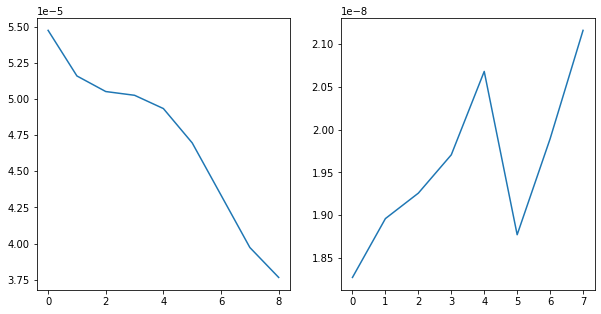

In [22]:
fix,ax = plt.subplots(1,2,figsize=(10,5))
angl = df["angle"].tolist()[20::20]
corrected = np.transpose([rot(x,-(angl[i]-df["angle"].loc[0])) for i,x in enumerate(np.diff(df[["comx","comy"]].to_numpy(),axis=0)[20::20])])
corrected.mean(axis=1)
ax[0].plot([np.linalg.norm(x) for x in corrected.T])
ax[1].plot(np.diff(df["angle"][20::20]))

In [29]:
[np.mean(np.diff(np.mean(df[[f"x{i}" for i in range(8)]],axis=1))),
 np.mean(np.diff(np.mean(df[[f"y{i}" for i in range(8)]],axis=1)))]

[4.948908270886527e-06, -4.948852033863379e-06]

In [8]:
def phase_heatmap(df, colname, ax, title, size=110, minv=None, maxv=None, phase1="phase 0", phase2="phase 1"):
    if minv == None and maxv == None: 
        minv = df[colname].min(); maxv = df[colname].max()
    ax.set(xlim=(0,2),ylim=(0,2),title=title); ax.set_aspect(1)
    ax.scatter(df[phase1], df[phase2], cmap=mpl.colormaps["plasma"],marker="s",
        c=mpl.colors.Normalize(minv,maxv)(df[colname]),s=size)
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=mpl.colormaps["plasma"],norm=mpl.colors.Normalize(minv,maxv))

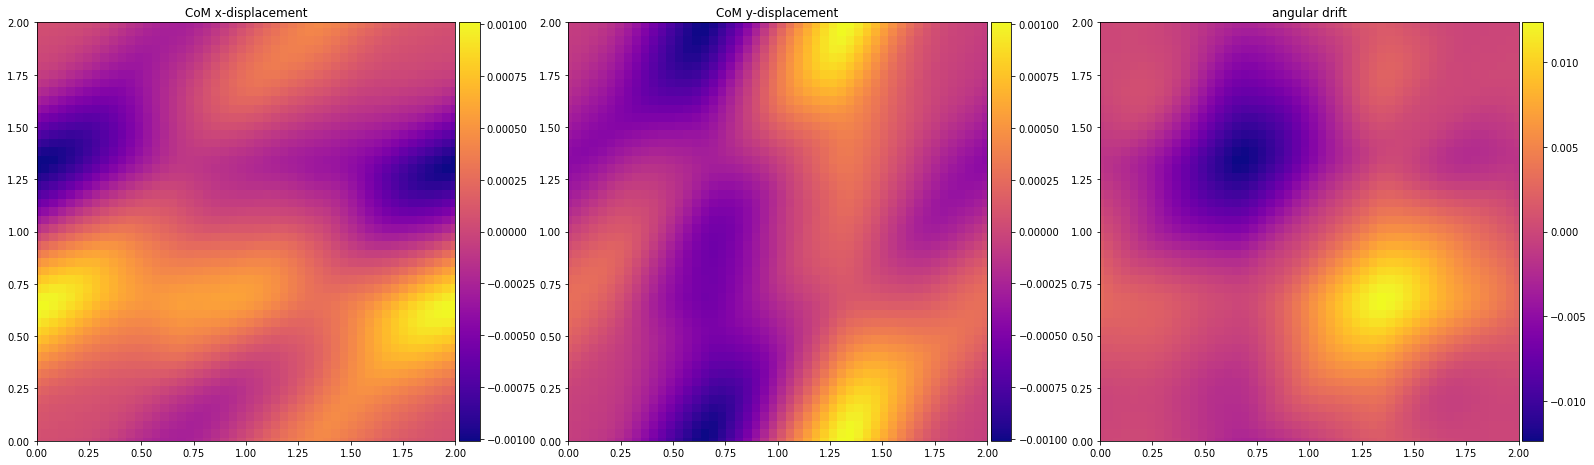

In [9]:
fig, ax = plt.subplots(1,3,figsize=(27,9)); arr = df1[["d_comx","d_comy"]].to_numpy()
mi = arr.min(); ma = arr.max()
phase_heatmap(df1,"d_comx",ax[0],"CoM x-displacement",size=80,minv=mi,maxv=ma)
phase_heatmap(df1,"d_comy",ax[1],"CoM y-displacement",size=80,minv=mi,maxv=ma)
phase_heatmap(df1,"d_theta",ax[2],"angular drift",size=80)

In [31]:
df1

,Unnamed: 0,phase 0,phase 1,phase 2,d_theta,d_comx,d_comy
0,0,0.0,0.000000,0,5.577395e-09,0.000007,-0.000007
1,1,0.0,0.040816,0,-4.882317e-05,0.000017,-0.000002
2,2,0.0,0.081633,0,-1.044656e-04,0.000029,0.000002
3,3,0.0,0.122449,0,-1.434292e-04,0.000044,0.000007
4,4,0.0,0.163265,0,-1.513382e-04,0.000064,0.000012
...,...,...,...,...,...,...,...
2495,2495,2.0,1.836735,0,9.945090e-05,-0.000046,-0.000040
2496,2496,2.0,1.877551,0,6.325040e-05,-0.000031,-0.000029
2497,2497,2.0,1.918367,0,2.303680e-05,-0.000018,-0.000020
2498,2498,2.0,1.959184,0,1.026369e-05,-0.000004,-0.000013


## Constant Phase Integration 

In [10]:
def interpolator(df,idx_fixed,n_units):
    cols = [f"phase {i}" for i in range(n_units)]; cols.remove(f"phase {idx_fixed}")
    return LinearNDInterpolator(df[cols],df[["d_comx","d_comy","d_theta"]])

def integrate_step(pos_com,angle,phases,idx_fixed,interpolator):
    if idx_fixed == False:
        phi = np.array(phases)
    else:
        phi = np.array(phases) - phases[idx_fixed]; phi = np.delete(phi,idx_fixed); 
    res = interpolator(phi % ModelParameters.t_cycle)  # assumes actuation cycle 2s
    c, s = np.cos(angle), np.sin(angle); R = np.array(((c, -s), (s, c)))  # _| ([[0,1],[1,1]]) shape is zero deg
    return pos_com + np.dot(R,res[0,:2]), angle + res[0,2]

In [11]:
interpolator1 = interpolator(df1,2,3)

In [12]:
def constant_phase_integrate(init_pos,init_angle,phases,n_steps,idx_fixed,interpolator):
    pos = init_pos; ang = init_angle; trajectory = []
    for i in range(n_steps):
        pos, ang = integrate_step(pos,ang,phases,idx_fixed,interpolator)
        trajectory.append([i*ModelParameters.t_cycle,pos[0],pos[1],ang])
    return np.array(trajectory)

In [13]:
def reference_simulation_1(phi1=[0.5,1.5,0],ang1=np.pi*3/4):
    model = MassSpringModel(f"test", np.array([[0,1],[1,1]]), 500, rotation_angle=ang1) 
    mat = prepare_em_standard(len(model.blocks)); model.set_phases(phi1)
    mat[:,9] = [0.04,0.04,0.04]; mat[:,10] = np.full(3, 1); mat[:,12] = [1,1,1]
    m2, sol, edata = integrate_model(model,mat,learning=False)
    return v_x_angle(pd.DataFrame(sol.y.T[:,-16:],
        columns=np.array([[f"x{i}", f"y{i}"] for i in range(8)]).flatten().tolist()).assign(t=sol.t),init_angle=ang1)

def pretend_simulation_1(phi,ang,com_start):
    path = pd.DataFrame(constant_phase_integrate(com_start,
        ang, phi, 500 // ModelParameters.t_cycle,2,interpolator1),columns=["t","comx","comy","angle"])
    return path.assign(angle = np.rad2deg(path.angle))

In [18]:
ref1 = reference_simulation_1([0.5,1.5,0],np.pi*3/4)
test1 = pretend_simulation_1([0.5,1.5,0],np.pi*3/4,ref1[["comx","comy"]].loc[0].tolist())

Integrated in 121.7763 seconds


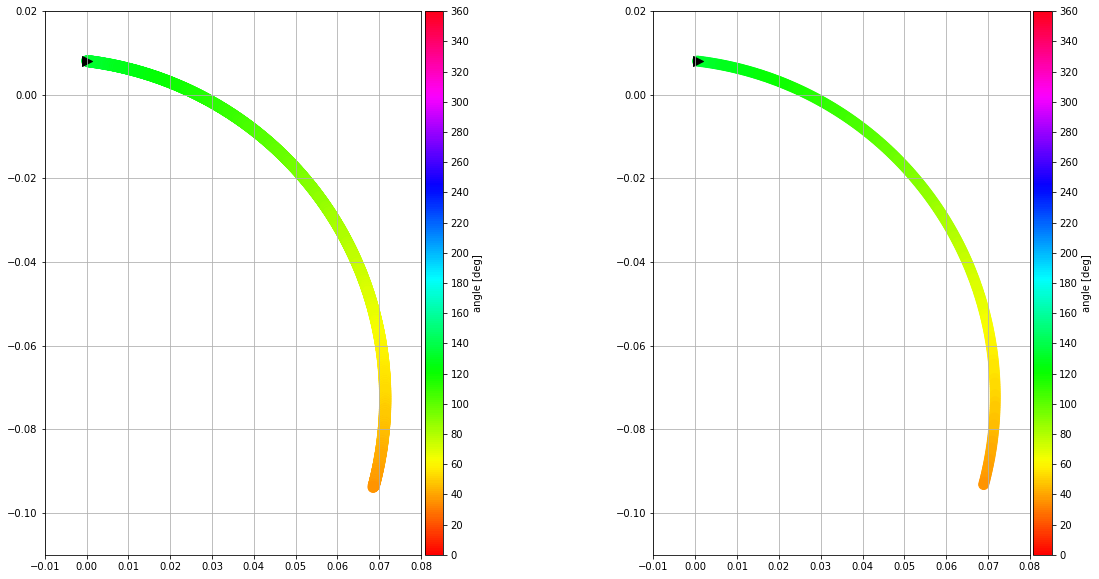

In [19]:
fig, ax = plt.subplots(1,2,figsize=(20,10)); [(ax[i].set_xlim(-0.01,0.08),ax[i].set_ylim(-0.11,0.02),ax[i].grid()) for i in [0,1]]
colour_path_plt(ref1,ax[0],no_light=True)
colour_path_plt(test1,ax[1],no_light=True)

(0.0004028690668733126,
 0.0007951722037314174,
 0.0008825674948706798,
 0.4575861156852028)

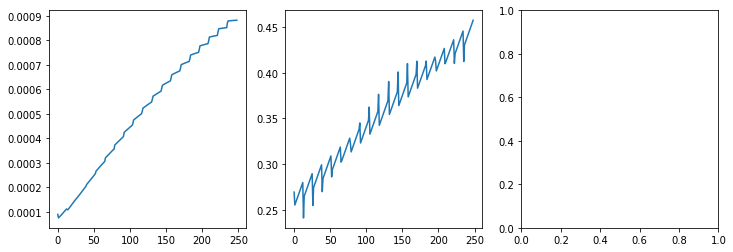

In [20]:
err1 = np.abs(test1[["comx","comy","angle"]].to_numpy()[:-1] - to_avg_bins(ref1,np.linspace(0,500,250))[["comx","comy","angle"]].to_numpy()[:-1])
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot([np.linalg.norm(x) for x in err1[:,:2]])
ax[1].plot(err1[:,2])
(err1[:,0].max(),err1[:,1].max(),max([np.linalg.norm(x) for x in err1[:,:2]]),err1[:,2].max())

## Copying Phases Integration

In [44]:
def reference_simulation_2():
    ang1 = np.pi *5/4
    model = MassSpringModel(f"test", np.array([[0,1],[1,1]]), 3000, rotation_angle=ang1) 
    mat = prepare_em_standard(len(model.blocks))
    mat[:,9] = [0.16,0.16,0.16]; mat[:,10] = np.full(3, 1); mat[:,12] = [1,1,1]; mat[:,1] = [0,0,0]; mat[:,2] = [0,0,0]
    res_df = motion_edata_to_df(SummaryFunctions.edata_and_sparse_motion(*integrate_model(model,mat)),8,3)
    return res_df, model.initial_CoM, model.initial_rotation

def fake_simulation_2(init_com,init_angle,n_steps,init_phases,phaselist,interpolator,idx_fixed=2):
    pos = init_com; ang = init_angle; phases = init_phases; trajectory = []
    for i in range(n_steps):
        pos, ang = integrate_step(pos,ang,phases,idx_fixed,interpolator)
        #if not np.isnan(phaselist[i,0]):
        phases = phaselist[i//3,:]  # 1 LC is currently 6s
        trajectory.append([i*ModelParameters.t_cycle,pos[0],pos[1],ang])
    df = pd.DataFrame(np.array(trajectory),columns=["t","comx","comy","angle"])
    return df.assign(angle=np.rad2deg(df.angle))

In [15]:
motion_edata_2, init_com2, init_ang2 = reference_simulation_2()

Integrated in 721.5937 seconds


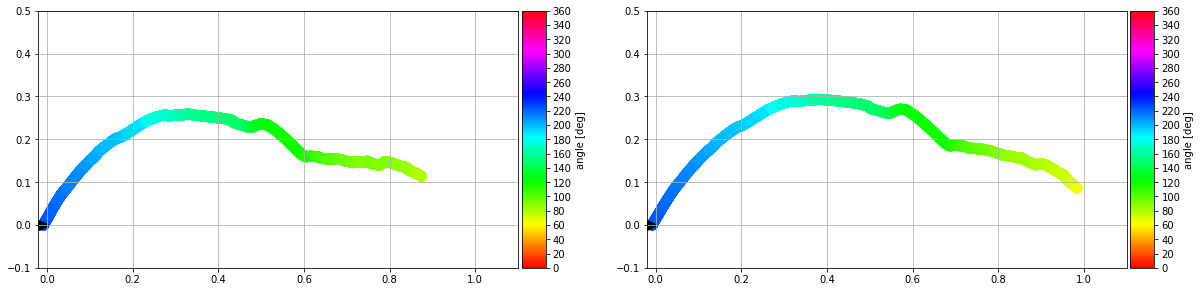

In [45]:
fig, ax = plt.subplots(1,2,figsize=(20,10)); [(ax[i].set_xlim(-0.02,1.1),ax[i].set_ylim(-0.1,0.5),ax[i].grid()) for i in [0,1]]
ref2 = v_x_angle(motion_edata_2,init_angle=init_ang2)
test2 = fake_simulation_2(init_com2,init_ang2,1499,[0,0,0],motion_edata_2.loc[where_change(motion_edata_2["learn cycle 0"].to_numpy())][
    [f"mem. phi {i}" for i in range(3)]].to_numpy(),interpolator1)
colour_path_plt(ref2,ax[0],no_light=True)
colour_path_plt(test2,ax[1],no_light=True)

(0.1141234878453693,
 0.0371694380470175,
 0.11594556634977417,
 13.491655293005152)

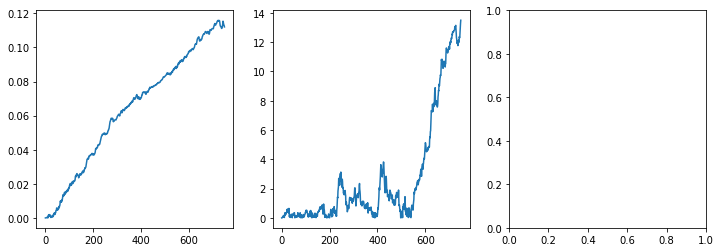

In [46]:
err2 = np.abs(test2[["comx","comy","angle"]].to_numpy()[:-1:2] - to_avg_bins(ref2,np.linspace(0,3000,750))[["comx","comy","angle"]].to_numpy())
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot([np.linalg.norm(x) for x in err2[:,:2]])
ax[1].plot(err2[:,2])
(err2[:,0].max(),err2[:,1].max(),max([np.linalg.norm(x) for x in err2[:,:2]]),err2[:,2].max())

## Learning Phases Integration 

### Exact Comparison (TODO)

In [156]:
def score_simulator(position,angle,block_com_vect,initial_com,light_x=20):
    # angle of 0 means shape is in the configuration described by mat
    c, s = np.cos(angle), np.sin(angle); R = np.array(((c, -s), (s, c))) 
    block_positions = np.array([position + np.dot(R,x - initial_com) for x in block_com_vect])
    return np.array([calculate_score_function(bpos,light_x) for bpos in block_positions])

def simulate_integration(model,mat,time_secs,interpolator,idx_fixed,tcl=ModelParameters.n_transient_cycles):  # TODO: njit
    pos = model.initial_CoM; ang = model.initial_rotation; block_CoM = model.blocks_CoM_list(); trajectory = []
    mem_score = np.zeros(len(model.blocks)).tolist(); curr_score = mem_score.copy(); mem_phi = mat[:,1].tolist().copy(); curr_phi = mem_phi.copy()
    phase_trajectory = []; waited_cycles = 0
    for i in range(time_secs // (tcl + 2)):
        # measurement 1, wait 1 actuation cycle
        light_ref = score_simulator(pos, ang - model.initial_rotation, block_CoM, model.initial_CoM)
        pos, ang = integrate_step(pos, ang, curr_phi, idx_fixed, interpolator)  
        trajectory.append([i*ModelParameters.t_cycle,pos[0],pos[1],ang % (2*np.pi)])
        phase_trajectory.append(np.array(mem_phi.copy()) % 2)
        # measurement 2
        curr_score = score_simulator(pos, ang - model.initial_rotation, block_CoM, model.initial_CoM) - light_ref
        # update phases
        for j in range(len(model.blocks)):
            mem_score[j], mem_phi[j] = flaky_light(curr_phi[j],mem_phi[j],curr_score[j],mem_score[j])
            curr_phi[j] = mem_phi[j] + (np.random.rand() - 0.5) * ModelParameters.t_cycle * mat[j,9]
        # wait transient cycles
        for _ in range(tcl + 1): 
            pos, ang = integrate_step(pos, ang, curr_phi, idx_fixed, interpolator)  
            trajectory.append([i*ModelParameters.t_cycle,pos[0],pos[1],ang % (2*np.pi)])
            phase_trajectory.append(np.array(mem_phi.copy()) % 2)
    return np.array(trajectory), np.array(phase_trajectory)

In [160]:
def compare_simulation_3(ang=np.pi * 6/7, T=50):
    sd = np.random.randint(1000,2000) 
    np.random.seed(sd)
    model = MassSpringModel(f"test", np.array([[0,1],[1,1]]), T, rotation_angle=ang) 
    mat = prepare_em_standard(len(model.blocks)); 
    mat[:,9] = [0.16,0.16,0.16]; mat[:,10] = np.full(3, 1); mat[:,12] = [1,1,1]; mat[:,1] = [0,0,0]; mat[:,2] = [0,0,0]
    init_mat = mat.copy()
    ref = motion_edata_to_df(SummaryFunctions.edata_and_sparse_motion(
        *integrate_model(model,mat,seed=sd)),len(model.nodes),len(model.blocks))
    test = simulate_integration(model, init_mat, T, interpolator1, 2, tcl=1)
    test_df = pd.DataFrame(test[0],columns=["t","comx","comy","angle"]); test_df = test_df.assign(angle=np.rad2deg(test_df.angle))
    return v_x_angle(ref,init_angle=ang), ref[["mem. phi 0","mem. phi 1","mem. phi 2"]], test_df, test[1]

In [161]:
comp3 = compare_simulation_3(T=3000)

[[  0.     0.     0.     0.     3.     0.     0.     0.     0.     0.16
    1.     0.     1.   -20.  ]
 [  0.     0.     0.     0.     3.     0.     0.     0.     0.     0.16
    1.     0.     1.   -20.  ]
 [  0.     0.     0.     0.     3.     0.     0.     0.     0.     0.16
    1.     0.     1.   -20.  ]]
Integrated in 736.9081 seconds


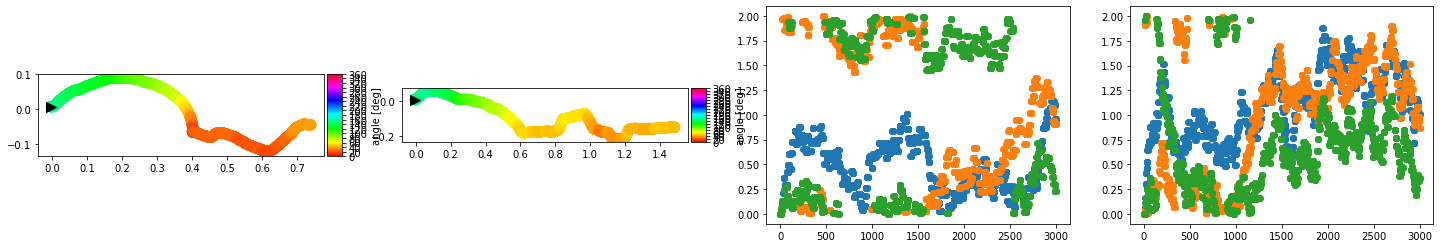

In [162]:
ig, ax = plt.subplots(1,4,figsize=(25,4))
colour_path_plt(comp3[0],ax[0],no_light=True)
colour_path_plt(comp3[2],ax[1],no_light=True)
ax[2].plot(comp3[1],"o")
ax[3].plot(comp3[3],"o")


### Statistical Comparison (TODO)

In [163]:
def fake_sim_3(ang,T,ds=[0.16,0.16,0.16]):
    model = MassSpringModel(f"test", np.array([[0,1],[1,1]]), T, rotation_angle=ang) 
    mat = prepare_em_standard(len(model.blocks)); mat[:,9] = ds; mat[:,10] = np.full(3, 1); mat[:,12] = [1,1,1]
    test = simulate_integration(model, mat, T // ModelParameters.t_cycle, interpolator1, 2) 
    test_df = pd.DataFrame(test[0],columns=["t","comx","comy","angle"]); test_df = test_df.assign(angle=np.rad2deg(test_df.angle))
    return test_df

In [164]:
def fake_ensemble(start_angle,t,n_sim):
    ens = [] 
    for i in range(n_sim): 
        df = fake_sim_3(start_angle,t,ds=[0.16,0.0,0.04])
        df = df.assign(vx = [0] + (np.linalg.norm(np.diff(df[["comx","comy"]].to_numpy(),axis=0),axis=1) / np.diff(df["t"])).tolist())
        df = df.assign(num=np.full(len(df),i))
        ens.append(df)
    return ens 

The output of the code below should look like the images from analyse_triangle_ds_sweep shown in the presentation (especially because this is also ds=[0.16,0.0,0.04], i.e. the optimal one we found).

<AxesSubplot: xlabel='t', ylabel='angle'>

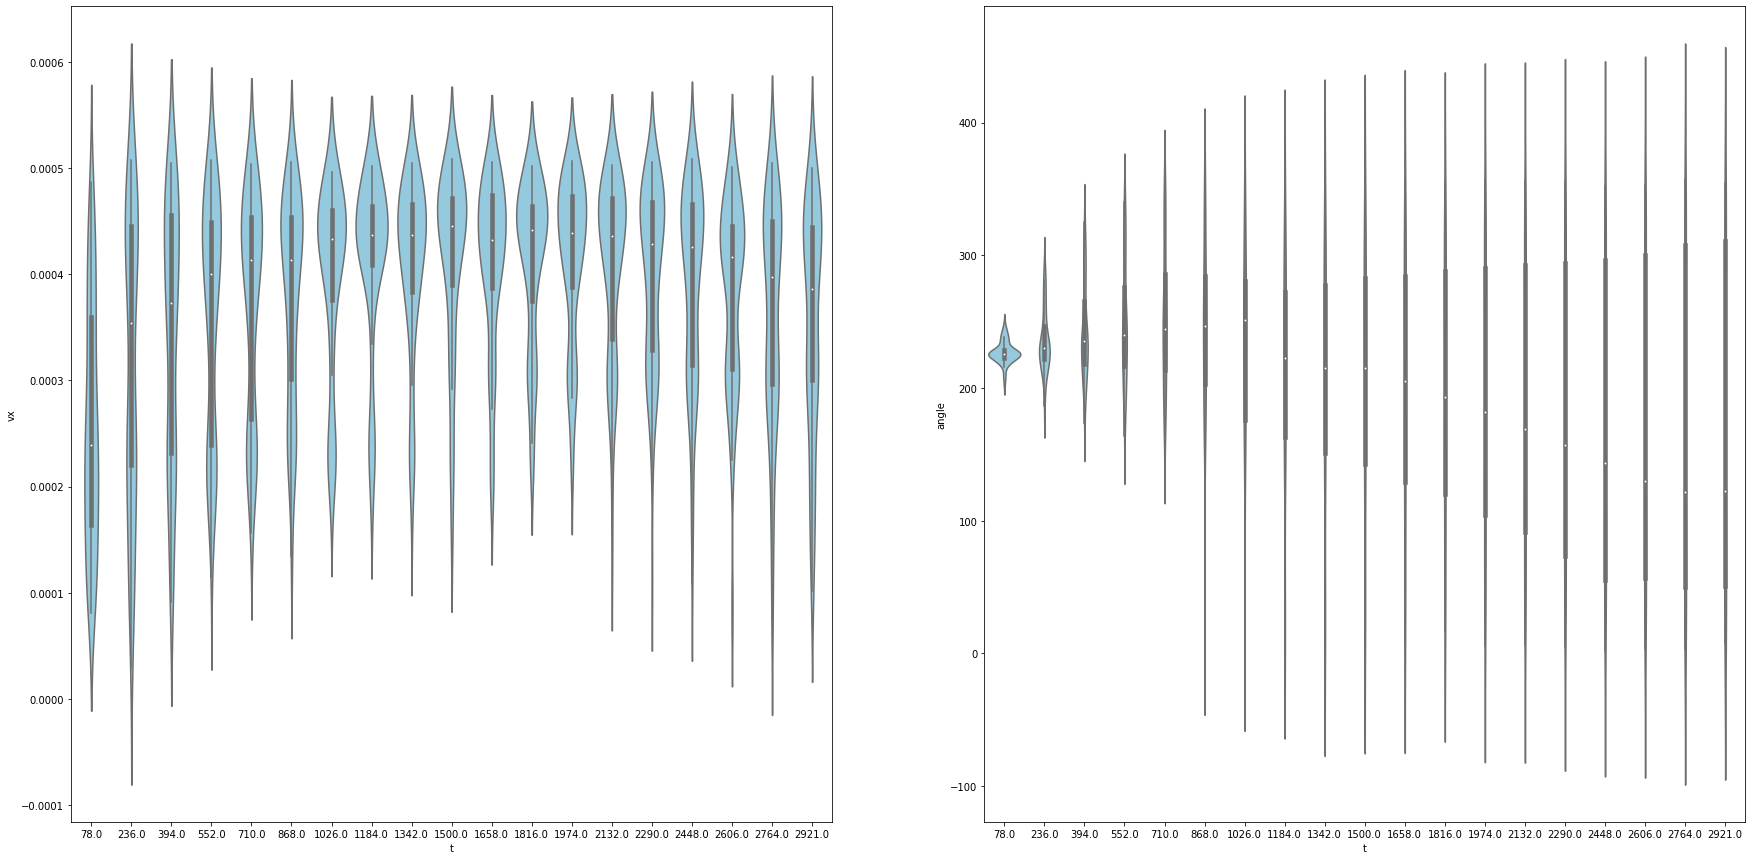

In [ ]:
fake_ens = fake_ensemble(np.deg2rad(225),9000,100)
fig, ax = plt.subplots(1,2,figsize=(30,15))
sns.violinplot(data=pd.concat([to_avg_bins(sim,np.linspace(0,9000,15)) for sim in fake_ens]),x="t",y="vx",ax=ax[0],color="skyblue",showmeans=True)
sns.violinplot(data=pd.concat([to_avg_bins(sim,np.linspace(0,9000,15)) for sim in fake_ens]),x="t",y="angle",ax=ax[1],color="skyblue",showmeans=True)

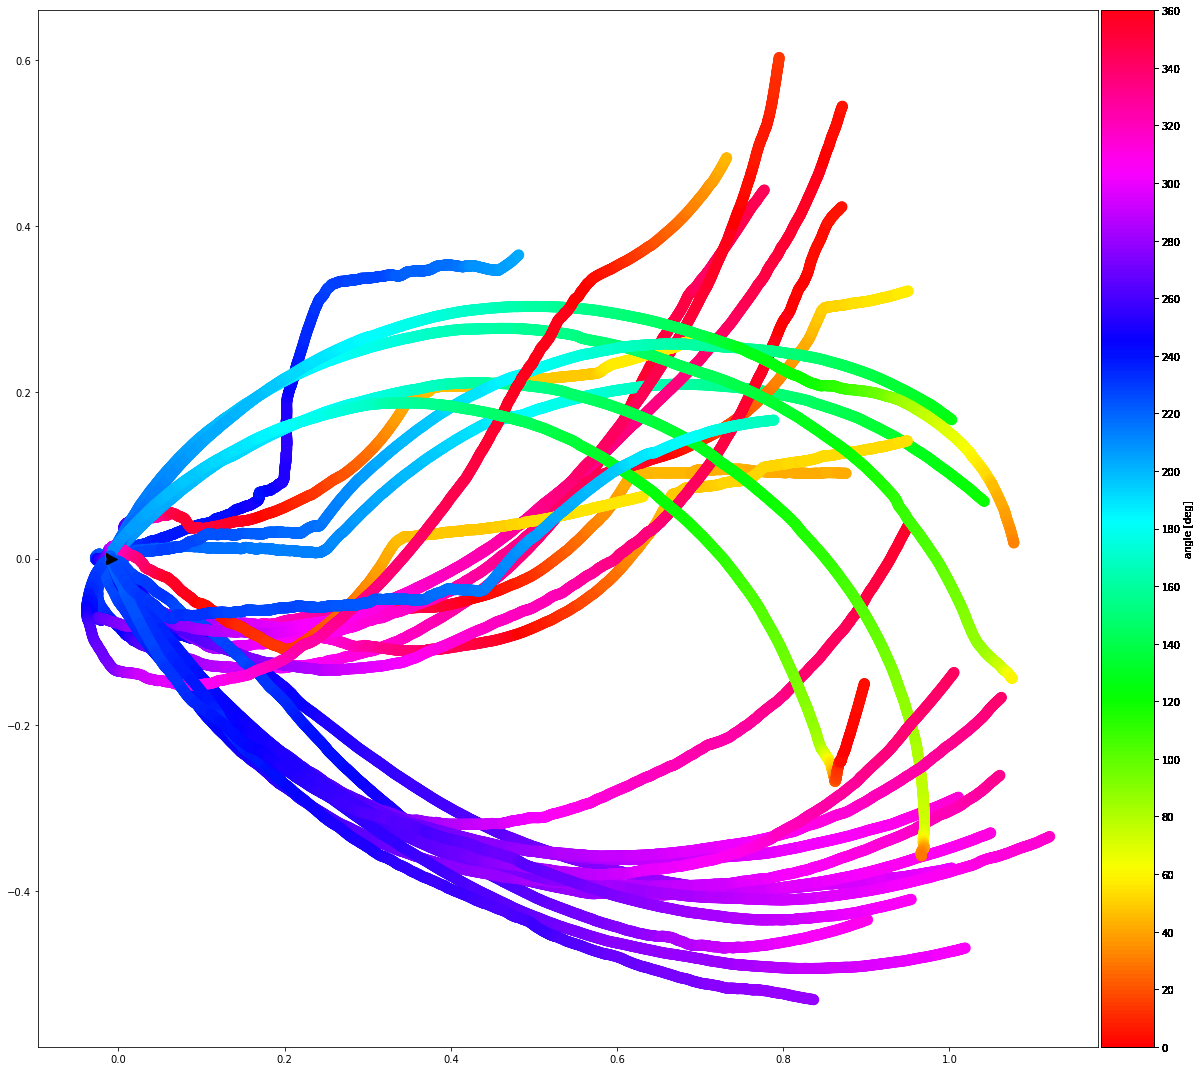

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
[colour_path_plt(dfr,ax,no_light=True) for dfr in fake_ens];

## Extract 

In [10]:
def xi_col(n):
    return np.array([[f"x{i}", f"y{i}"] for i in range(n)]).flatten()

def load_datafile_1(filename_sol,filename_events,n_nodes=12,init_ang=0): 
    data = pickle.load(open(filename_sol,"rb")); edata = pd.read_csv(filename_events); 
    start = np.array(list(data[1].values())).flatten()  # assumes index is in same order as displacement array 
    pos = pd.DataFrame(data[0].y[len(data[0].y)//2:,:].T + start,columns=xi_col(len(start)//2))
    df = to_avg_bins(pos.assign(t=data[0].t),np.linspace(0,16000,2000))[:-1]; df.index -= 1
    df = v_x_angle(df,num_nodes=n_nodes,init_angle=init_ang)
    return df.join(edata[[f"Phase {i}" for i in range(1,6)]])  # TODO

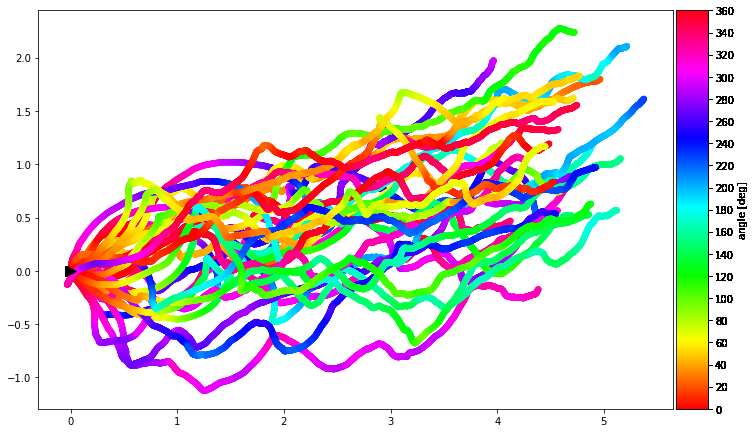

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

for i in range(30):
    motion_data = load_datafile_1(f"../data/experiment_files/03_11_2021/animation_data_num_{i}.p",
        f"../data/experiment_files/03_11_2021/event_data_num_{i}.csv")
    colour_path_plt(motion_data,ax,no_light=True,size=30)

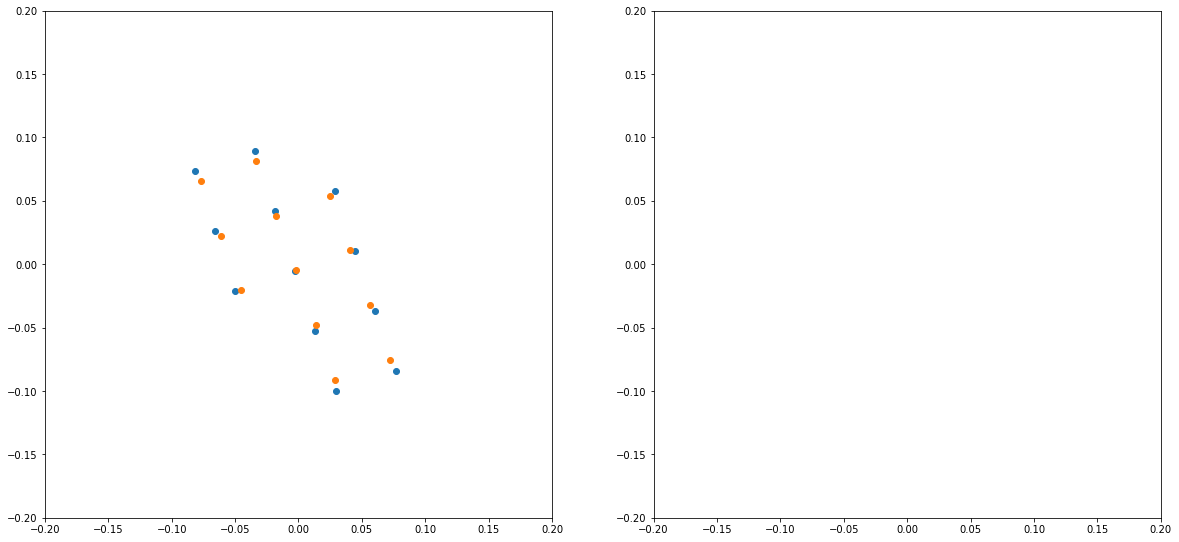

In [12]:
tst = pickle.load(open("../data/experiment_files/03_11_2021/animation_data_num_1.p","rb"))
nodes1 = np.array(list(tst[1].values())); nodes1 -= nodes1.mean(axis=0)
nodes2 = np.array([v.position for v in MassSpringModel("test", np.array([[0,0,1,1],[1,1,1,0]]),
    rotation_angle=np.deg2rad(110),t_end=0).nodes]); nodes2 -= nodes2.mean(axis=0)
fig, ax = plt.subplots(1,2,figsize=(20,10)); ax[0].scatter(*nodes1.T); 
ax[0].set_xlim(-0.2,0.2); ax[0].set_ylim(-0.2,0.2); ax[0].set_aspect(1); ax[1].set_aspect(1); ax[1].set_xlim(-0.2,0.2); ax[1].set_ylim(-0.2,0.2)
ax[0].scatter(*nodes2.T)

In [11]:
def extract_points(file1,file2,n_units=5,dt=8):  
    df = load_datafile_1(file1,file2)  # TODO: more generic
    df = df.assign(d_comx=np.concatenate((np.diff(df["comx"]),[np.nan])), 
                   d_comy=np.concatenate((np.diff(df["comy"]).tolist(),[np.nan]))) 
    df = df.assign(d_theta=np.concatenate((np.deg2rad(np.diff(np.unwrap(df["angle"],period=360))),[np.nan])))
    return df.drop(["comx","comy","vx","angle","t"],axis=1)[:-1]

Add the vertex points of the hypercube so the interpolation doesn't need to respect periodic boundary conditions.

In [12]:
#displacement_map(np.array([[1,1,0,0],[0,1,1,1]]),np.full(5,1),2,False,"5_test_vertices")
# that's not actually necessary, by definition all of these points have exactly the same value as (0,0,...,0) xD, however, necessary is:
displacement_map(np.array([[1,1,0,0],[0,1,1,1]]),np.full(5,1),2,False,"5_test_vertices",[-0.01,2.01])

(0.0, 0.0, 0.0, 0.0, 2.01) (0.0, 0.0, 0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 2.01, 0.0) (0.0, 0.0, 2.01, 0.0, 0.0) (0.0, 0.0, 2.01, 0.0, 2.01) (0.0, 0.0, 0.0, 2.01, 2.01) (0.0, 0.0, 2.01, 2.01, 2.01) (0.0, 0.0, 2.01, 2.01, 0.0) Integrated in 13.5296 seconds
Integrated in 13.7169 seconds
(0.0, 2.01, 0.0, 0.0, 0.0) (0.0, 2.01, 0.0, 0.0, 2.01) Integrated in 14.0604 seconds
Integrated in 13.9852 seconds
(0.0, 2.01, 0.0, 2.01, 0.0) Integrated in 14.2183 seconds
Integrated in 14.1785 seconds
(0.0, 2.01, 0.0, 2.01, 2.01) Integrated in 14.3015 seconds
(0.0, 2.01, 2.01, 0.0, 0.0) (0.0, 2.01, 2.01, 0.0, 2.01) (0.0, 2.01, 2.01, 2.01, 0.0) Integrated in 14.4911 seconds
(0.0, 2.01, 2.01, 2.01, 2.01) Integrated in 8.1828 seconds
(2.01, 0.0, 0.0, 0.0, 0.0) Integrated in 8.2788 seconds
(2.01, 0.0, 0.0, 0.0, 2.01) Integrated in 7.9522 seconds
(2.01, 0.0, 0.0, 2.01, 0.0) Integrated in 8.3386 seconds
(2.01, 0.0, 0.0, 2.01, 2.01) Integrated in 8.5349 seconds
(2.01, 0.0, 2.01, 0.0, 0.0) Integrated in 8.2442 second

In [13]:
cube_vertices = pd.read_csv("../data/experiment_files/19_12_2022/displacement_map_5_test_vertices.csv")
cube_vertices = cube_vertices.assign(**{f"Phase {i+1}": cube_vertices[f"phase {i}"] for i in range(5)})
cube_vertices = cube_vertices.drop([f"phase {i}" for i in range(5)] + ["Unnamed: 0"],axis=1)

In [14]:
points = []
for i in range(30):
    points.append(extract_points(f"../data/experiment_files/03_11_2021/animation_data_num_{i}.p",
        f"../data/experiment_files/03_11_2021/event_data_num_{i}.csv"))
points.append(cube_vertices)
total_sample = pd.concat(points)

In [15]:
total_sample

,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,d_comx,d_comy,d_theta
0,1.413135,1.226373,0.779072,1.671640,1.770491,-0.001143,-0.000222,-0.001206
1,1.387399,1.968340,0.032223,1.937465,1.902577,-0.001043,-0.000413,0.000510
2,1.417904,1.933153,0.047176,0.012052,0.002343,-0.001115,-0.000573,0.001857
3,1.437177,1.920395,0.033613,1.981560,1.882853,-0.001181,-0.000643,0.000568
4,1.412262,1.886962,0.074451,0.013280,1.921658,-0.001056,-0.000538,0.003934
...,...,...,...,...,...,...,...,...
27,2.010000,2.010000,0.000000,2.010000,2.010000,-0.000009,-0.000006,-0.000005
28,2.010000,2.010000,2.010000,0.000000,0.000000,-0.000001,-0.000008,-0.000016
29,2.010000,2.010000,2.010000,0.000000,2.010000,-0.000004,-0.000006,0.000011
30,2.010000,2.010000,2.010000,2.010000,0.000000,-0.000004,-0.000008,-0.000038


In [16]:
def cross_section(sample,axs,tol=0.1):  
    # axs is an array with values in the positions of phases that should be constant and None where you want to slice 
    filter_mask = np.full(len(sample),True); j = 0; selection = []
    for i,val in enumerate(axs):
        if val != None:
            filter_mask &= np.abs(sample[f"Phase {i+1}"] - val) <= tol  # TODO: naming convention
        else: 
            sample = sample.assign(**{f"phase {j}": sample[f"Phase {i+1}"]})
            selection.append(f"phase {j}"); j += 1; 
    return sample[filter_mask][selection + ["d_comx","d_comy","d_theta"]]

def glue_hypercube_copies(sample,n_units=5):  # TODO: naming convention; assumes t_cycle = 2
    copies = []
    for shift_vector in itertools.product(*[[-2,0,2] for _ in range(n_units)]):
        s_prime = sample.copy(); s_prime[[f"Phase {i+1}" for i in range(n_units)]] += list(shift_vector)
        copies.append(s_prime)
    return pd.concat(copies) 

In [17]:
len(total_sample)

59972

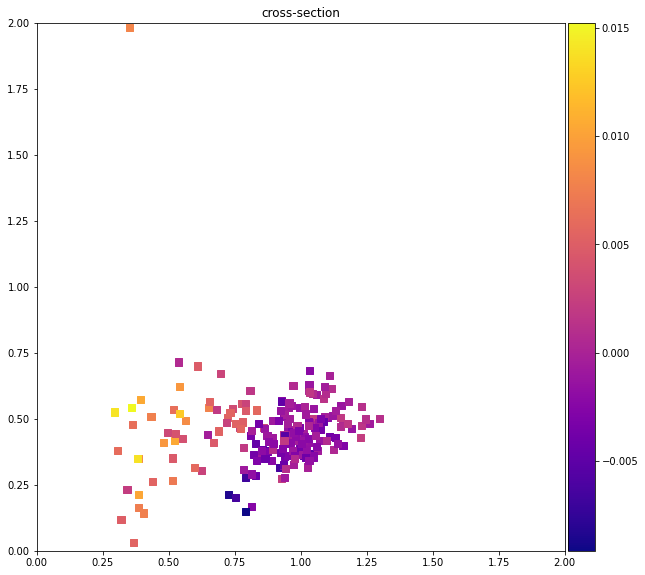

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10)); 
phase_heatmap(cross_section(total_sample,[None,1,None,1,1],tol=0.1),"d_theta",ax,"cross-section",size=50)

In [19]:
def get_interpolator(df,n_units=5):
    return LinearNDInterpolator(df[[f"Phase {i+1}" for i in range(n_units)]],
        df[["d_comx","d_comy","d_theta"]])

In [20]:
interpolator2 = get_interpolator(total_sample)

In [21]:
def interpolate_vals_grid(df,interpolator,val_lst,resolution=20):
    idxvary = np.where(np.array(val_lst) == None)[0]  # assuming there are only two indices to vary
    coords = np.full((resolution**2,len(val_lst)), val_lst)
    coords[:,idxvary[0]] = np.full((resolution,resolution),np.linspace(0,2,resolution)).reshape((resolution**2,))
    coords[:,idxvary[1]] = np.full((resolution,resolution),np.linspace(0,2,resolution)).T.reshape((resolution**2,))
    res = []
    for point in coords: 
        res.append([point[idxvary[0]], point[idxvary[1]]] + interpolator(point)[0].tolist())
    return np.array(res)

def interpolate_plot(df,gridvals,ax,colidx=2,size=50):
    ax.set(xlim=(0,2),ylim=(0,2))
    gr = gridvals[~np.isnan(gridvals[:,colidx])]
    minv = gr[:,colidx].min(); maxv = gr[:,colidx].max()
    ax.scatter(gr[:,0],gr[:,1], cmap=mpl.colormaps["plasma"],marker="s",
        c=mpl.colors.Normalize(minv,maxv)(gr[:,colidx]),s=size)
    ax.scatter(df["phase 0"].tolist(), df["phase 1"].tolist(),c="black",zorder=1)
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=mpl.colormaps["plasma"],norm=mpl.colors.Normalize(minv,maxv))
    return minv, maxv


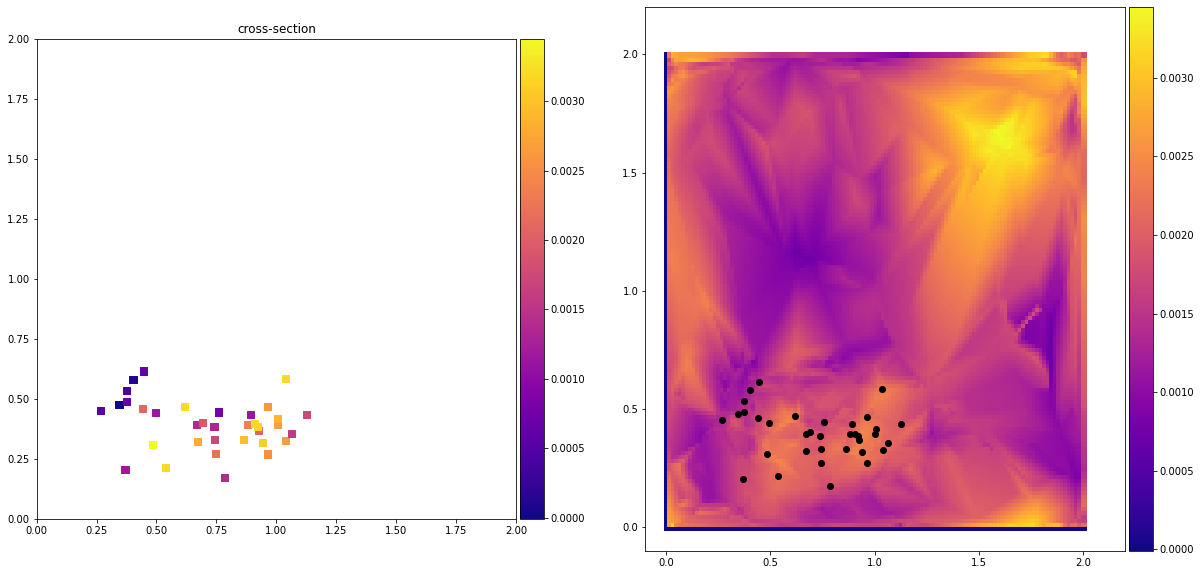

In [26]:
lab = [None,1,None,1,0.8]
pnts = cross_section(total_sample,lab,tol=0.05)
gridvals = interpolate_vals_grid(pnts,interpolator2,lab,resolution=120)

fig, ax = plt.subplots(1,2,figsize=(20,10))
mi, ma = interpolate_plot(pnts,gridvals,ax[1],colidx=2,size=25)
ax[1].set(xlim=(-0.1,2.2),ylim=(-0.1,2.2))
phase_heatmap(pnts,"d_comx",ax[0],"cross-section",size=50,minv=mi,maxv=ma)

In [23]:
def fake_sim_4(T,ang=-np.pi/4,ds=[0.04,0.04,0.04,0.04,0.04]):
    model = MassSpringModel(f"test", np.array([[1,1,0,0],[0,1,1,1]]), T, rotation_angle=ang) 
    mat = prepare_em_standard(len(model.blocks)); mat[:,9] = ds; mat[:,10] = np.full(len(model.blocks), 1); mat[:,12] = np.full(len(model.blocks),1)
    test = simulate_integration(model, mat, T // ModelParameters.t_cycle, interpolator2, False) 
    test_df = pd.DataFrame(test[0],columns=["t","comx","comy","angle"]); test_df = test_df.assign(angle=np.rad2deg(test_df.angle))
    return test_df


NameError: name 'fake_sim_4' is not defined

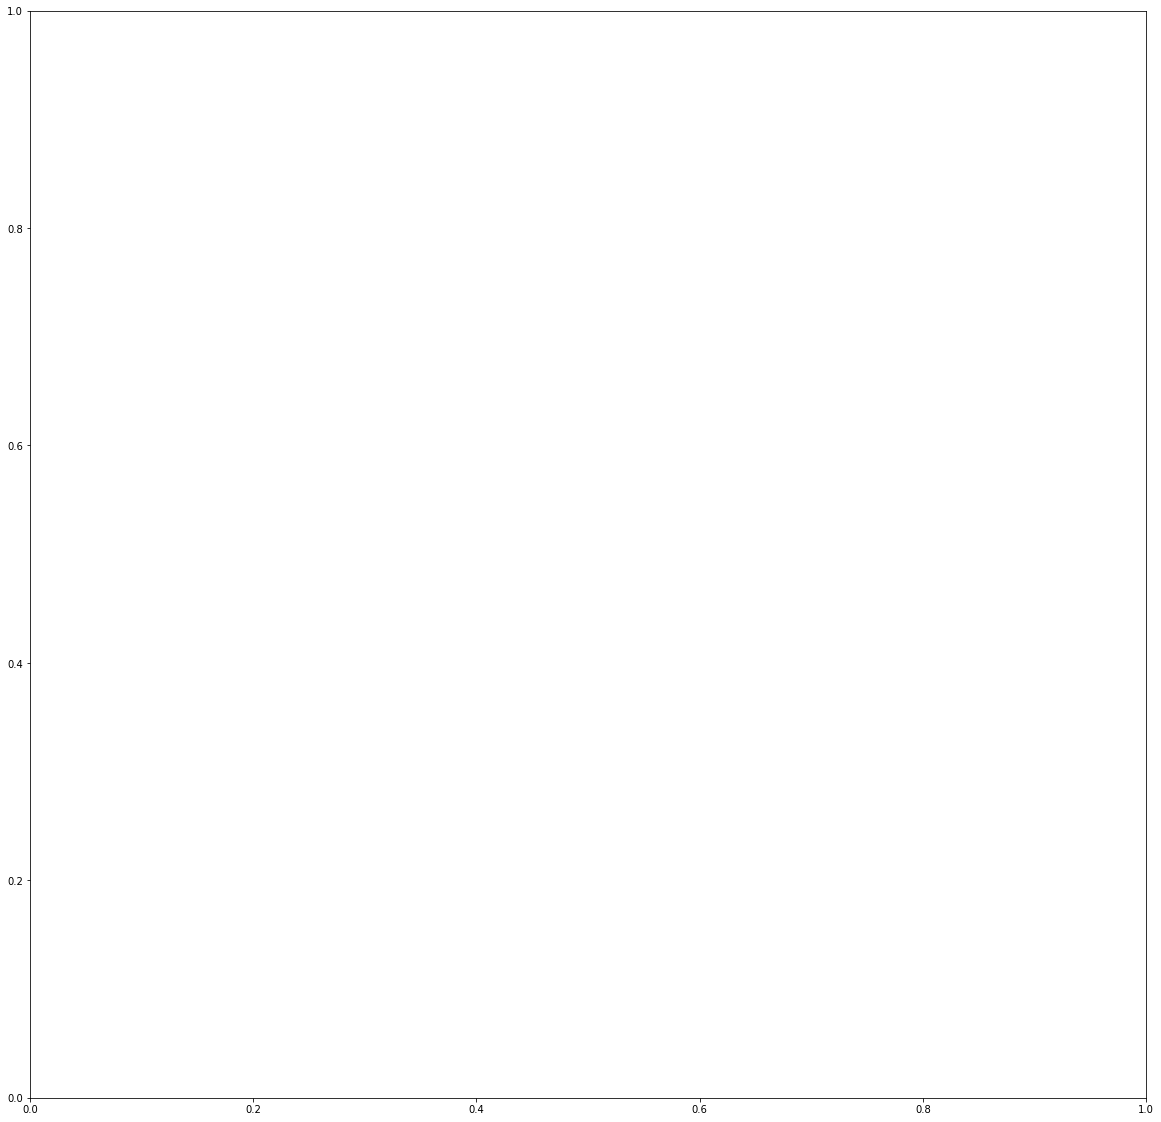

In [165]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
[colour_path_plt(fake_sim_4(16000,ang=np.deg2rad(110)),ax,no_light=True) for i in range(30)];